1.1. Describing the features : Keypoint detecting & drawing using SIFT

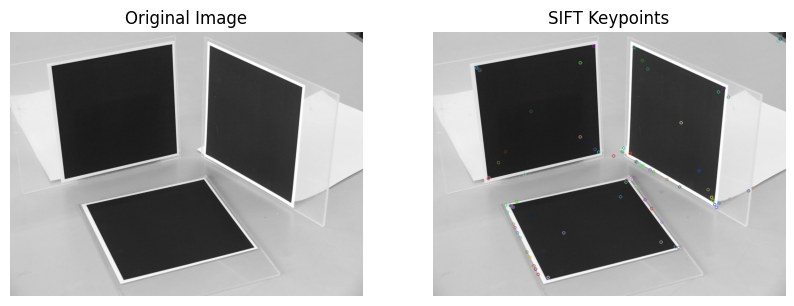

In [11]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

# Load the image
img = cv.imread('Images/Image2.jpg')
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Apply SIFT
sift = cv.SIFT_create()
kp = sift.detect(gray, None)

# Draw keypoints
img_with_kp = cv.drawKeypoints(gray, kp, img.copy())

# Display images using subplots
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

# Image with SIFT keypoints
plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(img_with_kp, cv.COLOR_BGR2RGB))
plt.title("SIFT Keypoints")
plt.axis("off")

# Show the plots
plt.show()

1.2. Describing the features : Draws the small circles on the locations of keypoints of SIFT

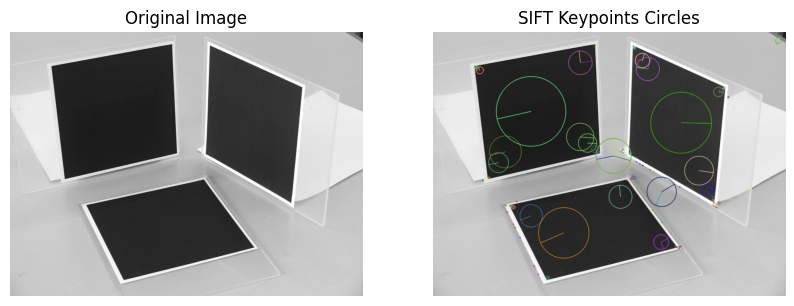

In [12]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

# Load the image
img = cv.imread('Images/Image2.jpg')
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Apply SIFT
sift = cv.SIFT_create()
kp = sift.detect(gray, None)

# Draw keypoints with rich details
img_with_kp = cv.drawKeypoints(gray, kp, img.copy(), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display images using subplots
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

# Image with SIFT keypoints
plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(img_with_kp, cv.COLOR_BGR2RGB))
plt.title("SIFT Keypoints Circles")
plt.axis("off")

# Show the plots
plt.show()

2. Matching : SSD Matching VS SIFT Matching

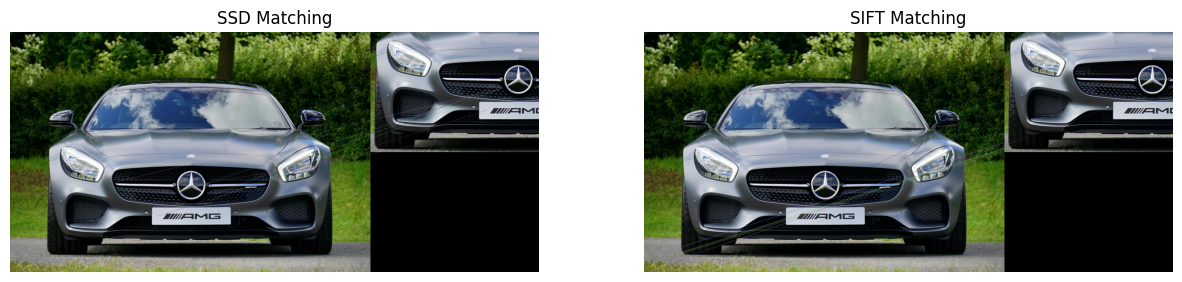

In [14]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

# Load images
img1 = cv.imread('Images/bense.jpg')  # queryImage
img2 = cv.imread('Images/benseCropped.jpg')  # trainImage

# Convert to grayscale
img1_gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
img2_gray = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)

# Initiate SIFT detector
sift = cv.SIFT_create()

# Find keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1_gray, None)
kp2, des2 = sift.detectAndCompute(img2_gray, None)

# Implement a simple pixel intensity descriptor (5x5 neighborhood)
def simple_descriptor(image, keypoints):
    descriptors = []
    for kp in keypoints:
        x, y = int(kp.pt[0]), int(kp.pt[1])
        patch = image[max(y-2, 0):min(y+3, image.shape[0]), max(x-2, 0):min(x+3, image.shape[1])]
        descriptors.append(patch.flatten())
    return np.array(descriptors, dtype=np.float32)

des1_simple = simple_descriptor(img1_gray, kp1)
des2_simple = simple_descriptor(img2_gray, kp2)

# Function to compute SSD distance
def ssd_match(des1, des2):
    matches = []
    for i, d1 in enumerate(des1):
        min_dist = float('inf')
        best_match = None
        for j, d2 in enumerate(des2):
            dist = np.sum((d1 - d2) ** 2)  # Sum of Squared Differences
            if dist < min_dist:
                min_dist = dist
                best_match = (i, j, min_dist)
        if best_match:
            matches.append(cv.DMatch(best_match[0], best_match[1], best_match[2]))
    return sorted(matches, key=lambda x: x.distance)

# Perform SSD matching
matches_ssd = ssd_match(des1_simple, des2_simple)

# Use OpenCV BFMatcher with SIFT descriptors
bf = cv.BFMatcher()
matches_sift = bf.knnMatch(des1, des2, k=2)

# Apply ratio test for SIFT matching
good_matches = []
for m, n in matches_sift:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Draw SSD matches
img_matches_ssd = cv.drawMatches(img1, kp1, img2, kp2, matches_ssd[:10], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Draw SIFT matches
img_matches_sift = cv.drawMatches(img1, kp1, img2, kp2, good_matches[:10], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display results
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(img_matches_ssd, cv.COLOR_BGR2RGB))
plt.title('SSD Matching')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(img_matches_sift, cv.COLOR_BGR2RGB))
plt.title('SIFT Matching')
plt.axis('off')
plt.show()

3. Brute-Force Matching with ORB Descriptors

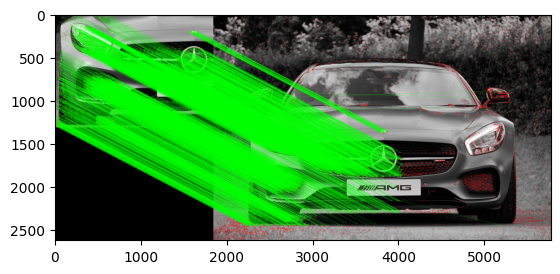

(<matplotlib.image.AxesImage at 0x16180de20d0>, None)

In [13]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

img1 = cv.imread('Images/benseCropped.jpg',cv.IMREAD_GRAYSCALE)          # queryImage
img2 = cv.imread('Images/bense.jpg',cv.IMREAD_GRAYSCALE) # trainImage

# Initiate SIFT detector
sift = cv.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

flann = cv.FlannBasedMatcher(index_params,search_params)

matches = flann.knnMatch(des1,des2,k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv.DrawMatchesFlags_DEFAULT)

img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)

plt.imshow(img3,),plt.show()

Q1. Extract and match interest points from a pair of images using the SIFT detector and descriptor. 

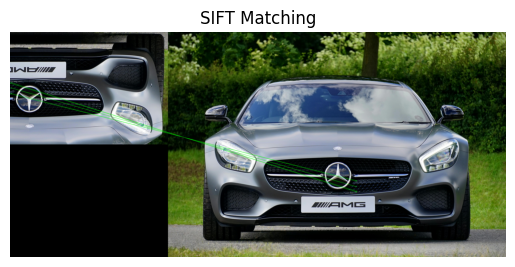

In [17]:
import cv2 as cv
import matplotlib.pyplot as plt

# Load images
img1 = cv.imread('Images/benseCroppedRotated.jpg')  # queryImage
img2 = cv.imread('Images/bense.jpg')  # trainImage

# Convert to grayscale
img1_gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
img2_gray = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)

# Initiate SIFT detector
sift = cv.SIFT_create()

# Find keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1_gray, None)
kp2, des2 = sift.detectAndCompute(img2_gray, None)

# Use OpenCV BFMatcher with SIFT descriptors
bf = cv.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Apply ratio test for SIFT matching
good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]

# Draw SIFT matches with green lines
img_matches_sift = cv.drawMatches(
    img1, kp1, img2, kp2, good_matches[:10], None,
    matchColor=(0, 255, 0),  # Green match lines
    flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

# Display result
plt.imshow(cv.cvtColor(img_matches_sift, cv.COLOR_BGR2RGB))
plt.title('SIFT Matching')
plt.axis('off')
plt.show()


In [ ]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

# Load images
img1 = cv.imread('Images/benseCropped.jpg', cv.IMREAD_GRAYSCALE)          # queryImage
img2 = cv.imread('Images/bense.jpg', cv.IMREAD_GRAYSCALE) # trainImage

# Initiate SIFT detector
sift = cv.SIFT_create()

# Find keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)  # or pass an empty dictionary

flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0, 0] for _ in range(len(matches))]

# Ratio test as per Lowe's paper
for i, (m, n) in enumerate(matches):
    if m.distance < 0.7 * n.distance:
        matchesMask[i] = [1, 0]

# Drawing parameters
draw_params = dict(matchColor=(0, 255, 0),  # Green for good matches
                   singlePointColor=(255, 0, 0),  # Red for keypoints
                   matchesMask=matchesMask,
                   flags=cv.DrawMatchesFlags_DEFAULT)

# Draw matches
img_matches = cv.drawMatchesKnn(img1, kp1, img2, kp2, matches, None, **draw_params)

# Display results using subplot
plt.figure(figsize=(15, 5))

# Show first image (query image)
plt.subplot(1, 3, 1)
plt.imshow(img1, cmap='gray')
plt.title("Query Image")
plt.axis("off")

# Show second image (train image)
plt.subplot(1, 3, 2)
plt.imshow(img2, cmap='gray')
plt.title("Train Image")
plt.axis("off")

# Show the matched keypoints
plt.subplot(1, 3, 3)
plt.imshow(cv.cvtColor(img_matches, cv.COLOR_BGR2RGB))
plt.title("SIFT Matching (FLANN)")
plt.axis("off")

# Show the plot
plt.tight_layout()
plt.show()
